In [16]:
%matplotlib inline


In [27]:
import diebold_Li_helpers as DL
reload(DL);
import plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
py.offline.init_notebook_mode()

# <center> Recreating Diebold and Li's Forecasting of Term Structure Yields </center>
## <center> Michael Lee </center>
## <center> In Fullfillment of Time Series Econometrics, Spring 2016 </center>


Diebold and Li's 2005 paper extends the work of Nelson-Siegel by forecasting the three exponential componenets used by Nelson and Siegel to fit the yield curve via autoregressive models. Diebold and Li are able to show that simple OLS models can be used to fit the Nelson-Siegel curve at each time period, and an autoregressive model of lag one can accurately forecast the fitted coefficients out of sample. This paper not only recreates and verifies Diebold and Li's work but also extends upon it by utilizing wavelet decomposition to seperate trends of varying time scales in forecasting. 

The Model is created using the python programming language, and is hosted interactively. 

Tags: _Nelson-Siegel, Diebold-Li, yield curves, wavelets_


!['Flowchart for the beta fits'](Assets/yieldlots.png)
<center>Yield Curves for Varying Maturities, 1980-2000</center>

## Background
Term sturcture forecasting has many applications in both fixed-income portfolio management and risk management. The term strucutre a bond can be described the yield paid out for fixed maturity dates. Term structure modeling has traditionally been done from two mutually exclusive points of view: no-arbitrage and equilibrium modeling. Both of these traditons had different focuses and therefore different problems when applied to forecasting. Diebold and Li instead use the Nelson-Siegel exponential components framework to fit the term structure using three factors which can then be forecasting using autoregressive models. The advantage of this methodolgy will be demonstrated in this paper, but briefly are: the fitted components have economic interpretations, and allows for easy identifation using traditional OLS methods. 

Diebold and Li apply autoregressive models (AR) to the fitted Nelson-Seigel parameters, and in effect forecast the yield curve itself. The resulting predictions are compared to standard benchmarks, and are shown to be considerably better in forecasting longer time horizion yields. 

I have extended Diebold and Li's AR(1) model by using wavelet decompositon to seperate time and frequency-dependent volatitilty, which are then forecasted independently using and autoregressive integrated moving average (ARIMA) model. The use of such wavelet decompositon models allows for the cyclic components of varying frequencies to be fitted and forecasted _in vacuo_. 

The structure of this paper is as follows:
1. [Introduction to bond yields](#yields) 
    2. [Nelson-Siegel curves](#NS)
2. [Fitting historical data via OLS](#OLS)
3. [Forecasting future term structures](#forecast)
4. Extension with wavelets
5. Concluding remarks


## <a name="yields"></a>The Nature of Yield Curves 
Let $P(\tau)$ denote the price of a $\tau-period$ discount bond, which is to say, the present value of a \$1.00 bond redeemable $\tau-periods$ in the future. If $y(\tau)$ is the continiously compounded yield to matruity (YTM), then the __discount curve__ can be defined as: 

\begin{equation}
    P(\tau) = e^{-\tau y(\tau)}
    \label{discount}
    \tag{eq: 1}
\end{equation}

The discount curve can be further related to the __forward rate__ curve, defined as:

\begin{equation}
    f(\tau) = \frac{-P'(\tau)}{P(\tau)}
    \label{forward}
    \tag{eq: 2}
\end{equation}

If we combine \ref{discount} and \ref{forward}, we can in turn relate the __yield curve__ (the curve in interest), with the forward rate curve (which is easily observed from bond prices). 

\begin{equation}
    y(\tau) = \frac{1}{\tau} \int_0^\tau f(u)du
    \label{yield}
    \tag{eq: 3}
\end{equation}



### <a name="NS"></a> Nelson-Siegel Yield Curves
One of the traditional difficulties in fitting yield curves has been the multitude of different forms they can take. Nelson and Siegel modeled the term structure using a three-component functional form which can be fitted using OLS regression. Where $\tau$ is the maturity date and $\lambda$ controls the exponential decay rate. 


$$\begin{equation}
    f_t(\tau) = \beta_1^t + \beta_2^t e^{-\lambda_t \tau} + \beta_3^t \lambda e^{-\lambda_t \tau}
    \tag{eq: 4}
\end{equation}$$

In Diebold and Li's paper, they factor the orignal Nelson-Seigel curve into a Laguerre function-- a polynomial times an exponential decay-- which have more intutive parameter interpretations. 

$$\begin{equation}
f_t(\tau) = \beta_1^t + \beta_2^t \left( \frac{1 -e^{-\lambda_t \tau}}{\lambda_t \tau} \right) + \beta_3^t \left(\frac{1 -e^{-\lambda_t \tau}}{\lambda_t \tau} - e^{-\lambda_t \tau}\right)
\tag{eq: 5}
\label{NS}
\end{equation}$$

In Diebold and Li's intpretation, $\beta_1$, $\beta_2$, $ \beta_3$ correspond to three latent dynamic factors: the long-term factor, the short-term factor, and the medium-term factor. These factors can be further interpreted as the level, slope, and curvature of the yield curve. _Figure 1_ shows the factor loading curves as a function of maturity date.

<!---
Here is the figure of NS curve loadings
-->

<figure>
<center>
<img src="Assets/NS_factors.png" alt="Nelson-Siegel Parameters" style="width: 500px; height:400px"/>
<figcaption> Fig. 1: Nelson-Siegel Parameters</figcaption>
</center>
</figure>

_Figure 1_ is typical of the average yield curve. While it possible that yield curves can be convex and decreasing, i.e. 10 year rates are lower than the 3 month rates, the average yield curve is increasing and concave. The shape of the curve is in turn governed by the variations in $\beta_1$, $\beta_2$, and $\beta_3$. Stylistically, yield curves are more volitle in the short-term than the long-run. Long rates are also more persistant than short rates.

Diebold and Li also assign empircial interpretations to each loading. $\beta_1$ corresponds to the 10-year yield, and will effect all terms equally. $\beta_2$ is defined as the difference between the 10-year yield and the 3-month yield. $\beta_3$, the medium-term loading is interpreted as the difference between twice the 24 month  yield and the sum of 120 and 3 month yields.

Loading | Emprical Interpretation (months)         | Nelson-Siegel Fit            
---     | -------------------------------------------------- |----------------
$\beta_1$| $y_t(120)$                        | 1                 
$\beta_2$| $y_t(120) - y_t(3)$               | $\frac{1 -e^{-\lambda_t \tau}}{\lambda_t \tau}$
$\beta_3$| $2y_t(24) -(y_t(120) + y_t(3))$    | $ \frac{1 -e^{-\lambda_t \tau}}{\lambda_t \tau} - e^{-\lambda_t \tau}$

<center> Table 1: Nelson-Siegel Loadings</center>
## <a name="OLS"></a> Fitting the Nelson-Siegel Curve to Historical Yields
Diebold and Li's model can be broadly viewed as a two-componet model: first they fit historical data to the Nelson-Siegel parameters using OLS; secondly, they forecast the Nelson-Siegel parameters using an autoregressive model. This section will detail the use of OLS in fitting the term structure.

### Diebold and Li's Dataset
Diebold and Li use end-of-month price quotes for US treasuries taken from January 1985 to Decemeber 2000 taken from The Chicago Booth Center from Research in Security Prices (CRSP) government bond files. These prices are filted such that bonds with options and those with maturity dates less than one month. The bonds are then converted into unsmoothed Fama-Bliss forward rates. Diebold and Li choose only bonds with fixed maturities, specifically those with maturity dates of 3, 6, 9, 12, 15, 18, 21, 24, 30, 36, 48, 72, 96, 108, and 120 months. A contour plot of the dataset used can be seen (and explored!) below.

#### A Quick Aside on Fama-Bliss Yields
Recall that yield curves are not directly obserable, but instead my be estimated via bond prices. Historically, this has been done following the vein of McColloch (1971, 1975) where the __discount curve__ is fitted using polynomial splines. However, fitting the yield curve via polynomial splines has issues, namely that the discount curve diverges at long maturities. Vasicek and Fong (1982) improved upon this discount curve fitting by using exponetial splines, which ensures that the yields converge at long maturities, but neccistates that the forward reates must be positive. 

Fama and Bliss (1987) took an alternative approach, and instead fitted the yield curve by estimating __forward rates__. These rates are referred to as "unsmoothed Fama-Bliss" forward rates, which are then converted into unsmoothed Fama-Bliss yields via \ref{yield}



In [3]:
# load in Diebold and Li's dataset
# fit the model and return the fitted beta parameters 
# and their residuals
beta_fits, residuals, ratedata = DL.loadData()

yieldCurve = DL.yieldContors(ratedata)
iplot(yieldCurve)

# PRESS [SHIFT] + [ENTER] to execute this code block 

You can plot the yield curve for indivual or a series of dates by adding them to the location variable below. Pick an index value between __[0, 191]__, or multiple dates by seperating the values by commas. 

Ex: loc = [1, 5, 189]

Ex: loc = [55]

In [4]:
loc = [0, 150, 143, 88 ]
DL.exampleYield(ratedata, loc)

### Fitting Yield Curves 
Each observed Fama-Bliss yield curve (monthly) must be fitted to the Nelson-Siegel curve. Recall however, that $\ref{NS}$ has the exponetial decay term $\lambda$, which makes the estimation nonlinear. Diebold and Li avoid having to employ nonlinear least squares by instead fixing $\lambda=.0609$, the value that maximizes the loading on $\beta_2$, the medium-term factor, with the justifacation being that $\lambda$ sets the maturity at which the loading on $\beta_2$ achieves a maxium. In _Figure 2_ the algorithm for fitting the yield curves is detailed. 

<figure>
<center>
<img src="Assets/OLSflow.png" style="width: 800px; height:480px"/>
<figcaption>Fig. 4: Flowchart for fitting in-sample yield curves</figcaption>
</center>
</figure>

Imagining a table (or dataframe) where each row is a different observation date, and each column the corresponding YTM _(1)_, we fit each row via OLS _(2)_ and save the three resulting $\beta$ parameters. More concretely:

`
i = 0 
for observation in dataset
    beta[i] = OLS.fit(observation, X)
    i += 1
end
 `
 
The result is a *[3 x N_observations]* table containing the OLS fits for each observation. Some summary statistics and goodness-of-fit tests are shown below.

//anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future

//anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:600: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



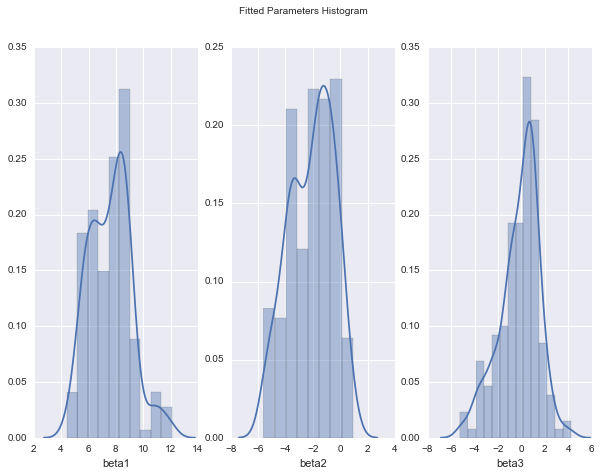

In [5]:
# Plot histograms for each of the fitted beta parameters
# non-interative
fig = DL.beta_dist(beta_fits)

In [6]:
# Plot the residuals for some of the maturity dates
DL.beta_resid(residuals)

#### Table 2
For comparison to Diebold and Li, I have included the same summary statistics of the OLS residuals that they provide in their paper (DL: Table 2). The correspondence is encouraging. Note that the high autocorrelation values for the term structure suggests that there are persistent discrepencies between the actual bond prices and what Nelson and Siegel predict. Diebold and Li suggest that these discrepencies could arise from tax and/or liquidity effects.

In [7]:
DL.table2(residuals)

,Mean,Std,Min,Max,MAE,RMSE,ACF(1),ACF(12),ACF(30)
3,-0.018284,0.080410,-0.331733,0.155740,0.060700,0.082258,0.777848,0.092878,-0.335279
6,-0.013473,0.041661,-0.141120,0.218058,0.031549,0.043682,0.290384,0.107583,-0.015771
9,-0.026008,0.061693,-0.200540,0.218223,0.051943,0.066803,0.704330,0.158475,-0.198754
12,0.013254,0.080082,-0.159594,0.266867,0.064369,0.080965,0.562485,0.229654,-0.246259
15,0.063149,0.049671,-0.062552,0.242228,0.067144,0.080263,0.649571,0.147223,-0.075218
18,0.047947,0.034878,-0.047638,0.165239,0.051662,0.059238,0.494133,0.088763,-0.018687
21,0.026009,0.029578,-0.091384,0.100584,0.033121,0.039329,0.368627,-0.049147,0.063735
24,-0.027371,0.044922,-0.190485,0.082034,0.037295,0.052504,0.666865,0.220948,0.067498
30,-0.017099,0.035609,-0.199743,0.098175,0.029053,0.039418,0.397610,0.038207,-0.088523
36,-0.037323,0.046060,-0.203361,0.127678,0.046674,0.059191,0.597620,0.001337,0.056748


#### Fig XX
Below we plot the empirical level, slope, and curvature and compare them to their corresponding fitted $\beta$ parameters. The empirical interpretations can be found in _Table 1_. 


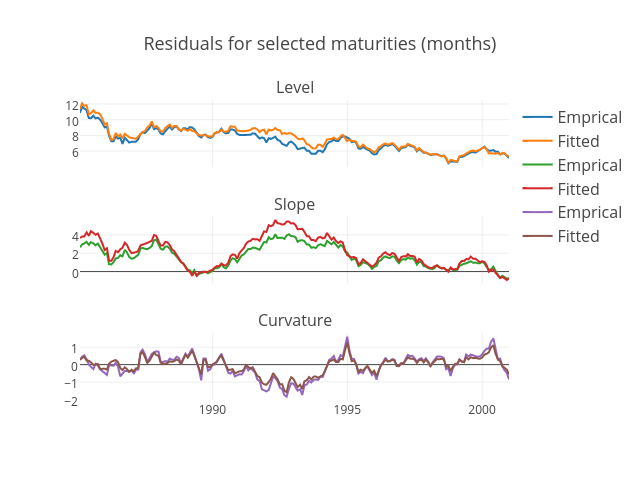

In [33]:
fig = DL.fig7(ratedata, beta_fits);
py.plotly.image.ishow(fig)

#### Table 3
For comparison to Diebold and Li, I have included the same descriptive statistics of the OLS beta fits that they provide in their paper (DL: Table 3). The data I present is identical to that of Diebold and Li, indicating that the model is replicated correctly. 

__NOTE:__ The augmented Dickey-Fuller (ADF) test for unit roots _strongly_ suggests that there are unit roots present in the $\beta_1$ and $\beta_2$ series. Diebold and Li briefly acknowledge this fact, but continue with their forecastings. Traditional wisdom suggests that AR forecasting can only be done with stationary data. In the interest of reproducing Diebold and Li's work, I will forecast these nonstationary series as well. 

In [9]:
DL.table3(beta_fits)

,Mean,Std,Min,Max,ACF(1),ACF(12),ACF(30),ADF
beta1,7.579812,1.523767,4.426683,12.088643,0.957332,0.482074,0.443502,-2.133352
beta2,-2.098801,1.607946,-5.615545,0.919011,0.969069,0.409026,-0.106957,-1.337617
beta3,-0.163536,1.685744,-5.250645,4.232782,0.901248,0.318661,-0.004457,-3.542007


## <a name="forecast"></a> FORECASTING INTO THE FUTURE
After fitting the observed yield curves to the Nelson-Seigel curves, we turn our attention towards forecasting the evolution of the parameters. Diebold and Li suggest using "the simplest great workhorse autoregressive models", to accomplish this task, and justify their selection over other, more sophisticated forecasting models. Specifically, Diebold and Li reject the use of a VAR model since there is little cross-variable interaction between parameters, and the truism that unrestricted VAR models tend to produce forecasts of economic variables. The authors instead choose to stack three indepenedent AR(1) models. 

The AR(1) specification is as follows:


$$\begin{equation}
\hat{f}_{t+h}(\tau) = \hat{\beta}_1^{t+h} + \hat{\beta}_2^{t+h} \left( \frac{1 -e^{-\lambda_t \tau}}{\lambda_t \tau} \right) + \hat{\beta}_3^{t+h} \left(\frac{1 -e^{-\lambda_t \tau}}{\lambda_t \tau} - e^{-\lambda_t \tau}\right)
\tag{eq: 6}
\label{AR}
\end{equation}$$

where, for $i=1,2,3$

\begin{equation}
\hat{\beta}_i^{t+h} = \hat{c}_i + \hat{\gamma}_i \hat{\beta}_i^{t}
\tag{eq: 7}
\end{equation}

The use of a single lag is justfied by the autocorrelation (ACF) and partial autocorrelation (PACF) plots of the $\beta$ parameters. The exponetial decay in the ACF after one lag is in line an autoregressive series of lag one. 
The PACF for all three $\beta$s is signficant for only one period, also inline with expectations.

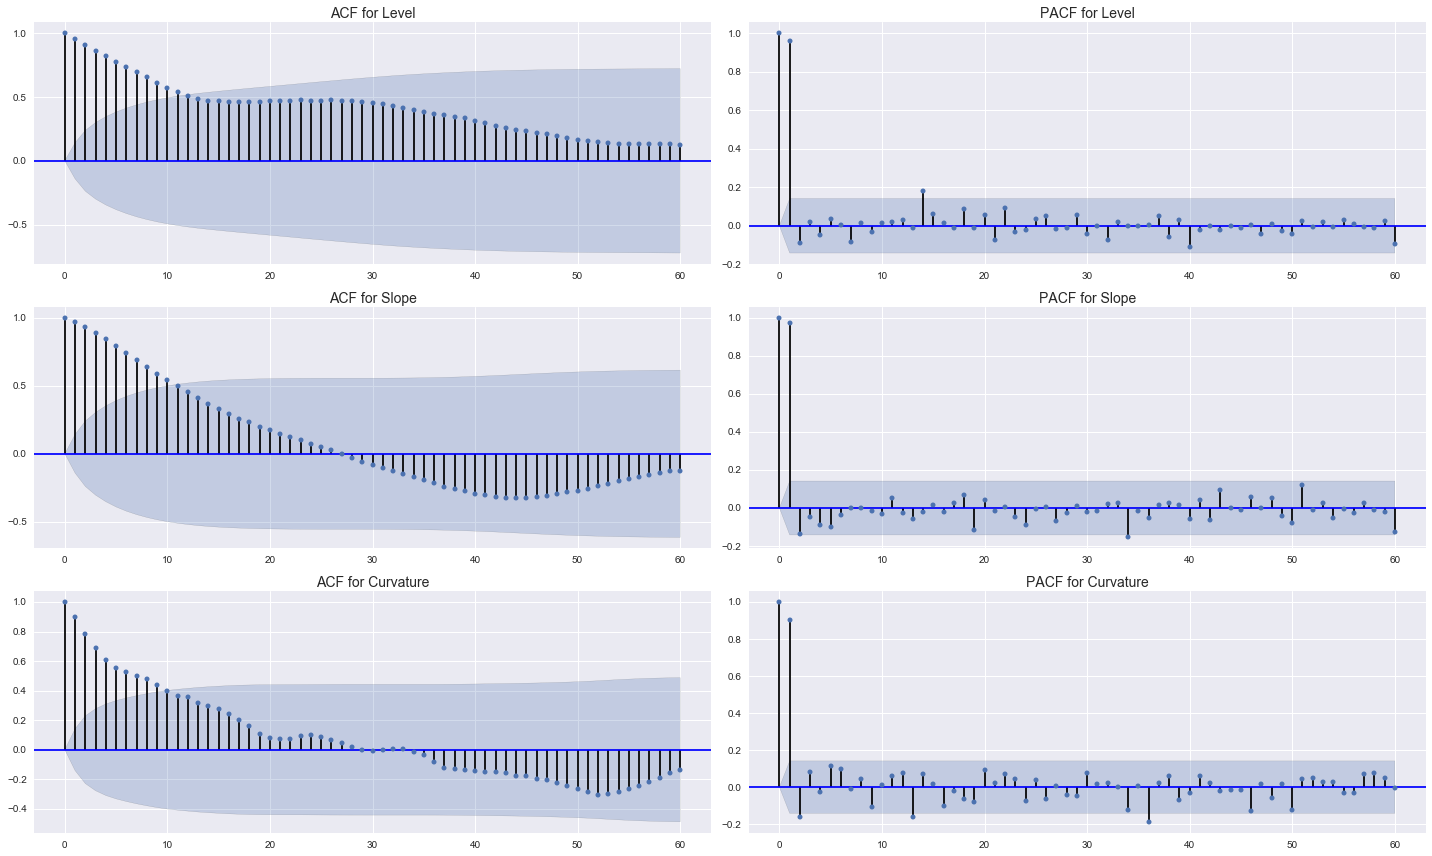

In [10]:
# plot the ACF for the betas and their residuals
DL.ACF_beta(beta_fits, residuals)

### Methodolgy
In order to test the fideltiy of the AR(1) model we will withhold a sample of the original dataset (1985-1994) to train the model, and then use in-sample forcasting to validate our model on predicting 1994-2000. 

<figure>
<center> 
<img src=Assets/ARflow.png width=640; height=480/>
<figcaption>AR(1) Flowchart</figcaption>
</center>
</figure>

Since in [Part 2](#OLS) we showed that the Nelson-Siegel parameters sufficiently describe the yield curve, __forecasting the Nelson-Seigel parameters is equivielent to forecasting the yield curve!__

In [17]:
import pdb
idx_1994 = ratedata.index.get_loc(dt.datetime.strptime('1994-01-31', '%Y-%m-%d'))
beta_fits_insample = beta_fits.iloc[:idx_1994]

# init the dataframe that will house [betas x [slope, intercept] x time] 
forecast_beta = pd.Panel(zeros((3,2,len(ratedata) - len(beta_fits_insample))),\
                         minor_axis=ratedata.iloc[idx_1994:].index, items=beta_names)

# init the dataframe that will house [time v. betas]
forecasts = pd.DataFrame(zeros((len(ratedata),3)), index=ratedata.index, columns=beta_names)
forecasts.ix[beta_fits_insample.index] = beta_fits_insample.values

# init the dataframe that will house time v. maturities
yields = pd.DataFrame(zeros((len(forecast_beta.minor_axis), len(maturities))),\
                      index=forecast_beta.minor_axis, columns= [str(mat) for mat in maturities])

yields.index =  minor_axis=ratedata.iloc[idx_1994:].index
# we recursively calculate the forecast using an AR1 model 
# that is updated with each realization
for t in range(idx_1994, len(ratedata)):
    # fit the AR model based on existing data
    for beta in beta_names:
        model = sm.tsa.AR(forecasts.ix[:t, beta]).fit(maxlag=1, method='cmle')
        # need to make this temp cause they might have used a constant 
        #                beta, [b,m], time period
        forecast_beta.ix[beta, :,forecasts.index[t]] = model.params.values 
#         pdb.set_trace()
        
        B_tmp = sum(forecast_beta.ix[beta, :,forecasts.index[t]] \
        * asarray([1.0, forecasts.ix[t-1, beta]]))
        # add these newly forecasted betas to the forecast beta dataframe
        # so we can uses them to forecast the next step
        forecasts.ix[t, beta] = B_tmp
        
    # now that we have fitted the beta coeffienets, lets use them to predict 
    # yields at specific taus
    yields.loc[forecasts.index[t],:] = forecasts.iloc[t, 0] + \
    forecasts.iloc[t, 1]*_load2(maturities) +\
    forecasts.iloc[t, 2]*_load3(maturities) 

NameError: name 'dt' is not defined

In [582]:
fitted_resid = pd.DataFrame(zeros((118,3)), columns = beta_fits.columns)

In [8]:
from statsmodels.graphics.api import qqplot

model = sm.tsa.AR(beta_fits.ix[:119, 'beta2'],
                  dates=beta_fits.index[:119], freq='M').fit(
    maxlag=1)

NameError: name 'sm' is not defined

In [9]:
fig = plt.figure()
plt.rcParams['font.size'] =  8
titlefont = {'fontsize': 10}
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(beta_fits.ix[:119, 'beta2'], 
                        lags=60, ax=ax1)

ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(beta_fits.ix[:119, 'beta2'],
                         lags=60, ax=ax2)

fig.tight_layout()

NameError: name 'plt' is not defined

In [770]:
# test for stationarity in the time series
adfresults = sm.tsa.stattools.adfuller(beta_fits.ix[:, 'beta1'], regression='c', autolag='BIC')
print(adfresults)



(-2.1333519801182472, 0.23131674250204143, 0, 191, {'5%': -2.8767942675230356, '1%': -3.465058702600837, '10%': -2.5749014492475535}, 44.724319915505696)


In [13]:
residuals

,3,6,9,12,15,18,21,24,30,36,48,60,72,84,96,108,120
Date,,,,,,,,,,,,,,,,,
1985-01-31,0.133864,-0.016588,-0.048169,-0.159594,-0.062552,0.054134,0.038374,-0.054310,0.098175,-0.074160,0.095848,-0.049160,0.099221,0.263426,-0.173961,-0.012325,-0.132223
1985-02-28,-0.004058,0.037714,-0.067023,0.001023,0.066342,0.058433,-0.036359,-0.054973,0.021488,-0.139261,0.062942,-0.072654,0.146040,0.248035,-0.144655,-0.041611,-0.081422
1985-03-29,-0.049858,0.046368,-0.059567,0.067993,0.045017,0.095575,-0.050337,-0.061947,-0.017991,-0.052030,-0.069114,-0.016572,0.156081,0.079323,-0.010920,-0.058157,-0.043864
1985-04-30,-0.007565,0.028360,-0.007047,-0.063509,0.055248,0.052345,0.016618,-0.055486,0.003456,-0.124267,0.056799,-0.111834,0.179614,0.159913,-0.011259,-0.037641,-0.133745
1985-05-31,0.109259,-0.050784,-0.147903,-0.014319,0.059678,0.050579,0.098541,-0.099718,-0.023701,-0.101284,0.105517,-0.081755,0.287187,-0.055818,-0.032839,-0.064833,-0.037809
1985-06-28,0.152819,-0.010894,-0.069882,-0.133039,0.001581,-0.020353,0.007437,-0.103249,-0.028678,0.065579,0.127409,-0.038097,0.399062,-0.070296,-0.030837,-0.160720,-0.087843
1985-07-31,0.102233,0.014641,-0.082877,-0.028666,-0.010495,-0.047638,0.003057,-0.116891,0.000924,0.009615,0.201760,-0.127553,0.379576,-0.091009,0.018768,-0.122055,-0.103391
1985-08-30,0.092100,0.032295,-0.037229,-0.146781,-0.035093,-0.003400,0.023493,-0.010851,-0.002458,-0.042102,0.160716,-0.090661,0.291018,-0.071446,-0.020302,0.017956,-0.157254
1985-09-30,0.113707,-0.096854,-0.004478,-0.146907,0.057768,0.095011,-0.011237,-0.024624,0.008306,-0.064176,0.087004,-0.008129,0.178796,-0.199362,-0.001331,0.080148,-0.063640


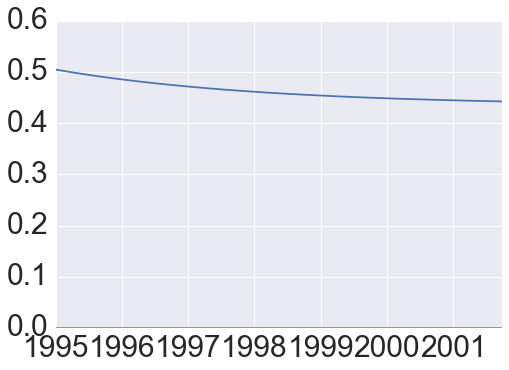

In [765]:
# predict insample first 
model = sm.tsa.AR(beta_demean,
                  dates=beta_demean.index, freq='M').fit(
    maxlag=1)
testPred = beta_fits.index[119]
val = model.predict(119, 200, dynamic=True)

plt.plot( val.index, val, val.index, ones((len(val),1))*beta_demean.mean() )

In [721]:
beta_fits.ix[:119,'beta2'].mean()

-2.8207533744903657

In [8]:
layout = go.Layout(
            titlefont=dict(
                size=24),
            legend= dict(
                font=dict(
                    size=18)),
            title='In-sample Betas',
            width=600,
            height=480,
    
            )
beta_fits.iplot(kind='scatter', layout=layout, title='In sample betas')

NameError: name 'go' is not defined

In [645]:
layout = go.Layout(
            width=600,
            height=480)
forecasts.iplot(kind='scatter', layout=layout, title='In sample betas')

In [499]:
error

,3,6,9,12,15,18,21,24,30,36,48,60,72,84,96,108,120
Date,,,,,,,,,,,,,,,,,
1994-01-31,-0.239949,-0.197319,-0.195768,-0.186180,-0.180003,-0.164131,-0.187810,-0.174559,-0.206361,-0.268120,-0.318674,-0.323816,-0.342000,-0.316272,-0.265394,-0.251168,-0.207055
1994-02-28,0.068013,0.144074,0.165334,0.242653,0.273373,0.244431,0.281440,0.265771,0.236953,0.197862,0.173441,0.136459,0.127960,0.174797,0.176248,0.183597,0.048468
1994-03-31,0.072602,0.249597,0.412947,0.548278,0.605744,0.652125,0.650911,0.685368,0.725544,0.733050,0.702519,0.654414,0.612339,0.689058,0.667893,0.703206,0.631705
1994-04-29,0.387366,0.674753,0.862539,0.969138,1.012532,1.002362,1.083003,1.091629,1.109801,1.083841,1.046974,0.946489,0.822597,0.830990,0.823033,0.872166,0.824172
1994-05-31,0.623887,0.958082,1.117617,1.171716,1.172203,1.209594,1.278160,1.242993,1.227165,1.193677,1.090264,0.990161,0.884232,0.877108,0.855200,0.881020,0.833422
1994-06-30,0.493777,0.866157,1.131725,1.212533,1.165263,1.262316,1.326871,1.311942,1.204114,1.179042,1.184891,1.106951,1.014780,0.969965,0.958959,0.977344,0.982040
1994-07-29,0.545674,0.821581,0.969440,0.997146,1.049254,1.075060,1.121659,1.047999,0.992168,0.929458,0.863389,0.782411,0.701813,0.638144,0.649906,0.664744,0.742641
1994-08-31,0.763241,0.908986,1.065369,1.089144,1.113752,1.140393,1.119087,1.148719,1.069883,0.994484,0.877332,0.794129,0.709932,0.670263,0.655668,0.665857,0.662870
1994-09-30,0.826168,1.241030,1.337149,1.434149,1.395364,1.471913,1.484746,1.486694,1.432846,1.352711,1.270322,1.192724,1.092770,1.030964,1.024900,1.036344,1.020394


In [609]:
error = (ratedata.ix[108:] - yields)
data = []
layout = go.Layout(
            width=600*2,
            height=480*2,
            title='Residuals from OLS fit',
            titlefont=dict(
                size=24),
            xaxis=dict(
                title='')

                )
            

for mat in maturities:
    mat = go.Box(
            y = residuals.loc[:,str(mat)].values,
            name='tau = '+ str(mat)
                        )
    data.append(mat)

fig = dict(data=data, layout=layout)
py.plotly.iplot(fig)

In [774]:
data = []


for beta in beta_fits.columns:
    mat = go.Box(
            y = beta_fits.ix[:, beta].values,
            name= beta
                        )
    data.append(mat)

fig = dict(data=data, layout=layout)
py.plotly.iplot(fig)

## ACF & PACF
here we will show that Diebold and Li were justified in using an AR(1) model by plotting hte PACF and ACF

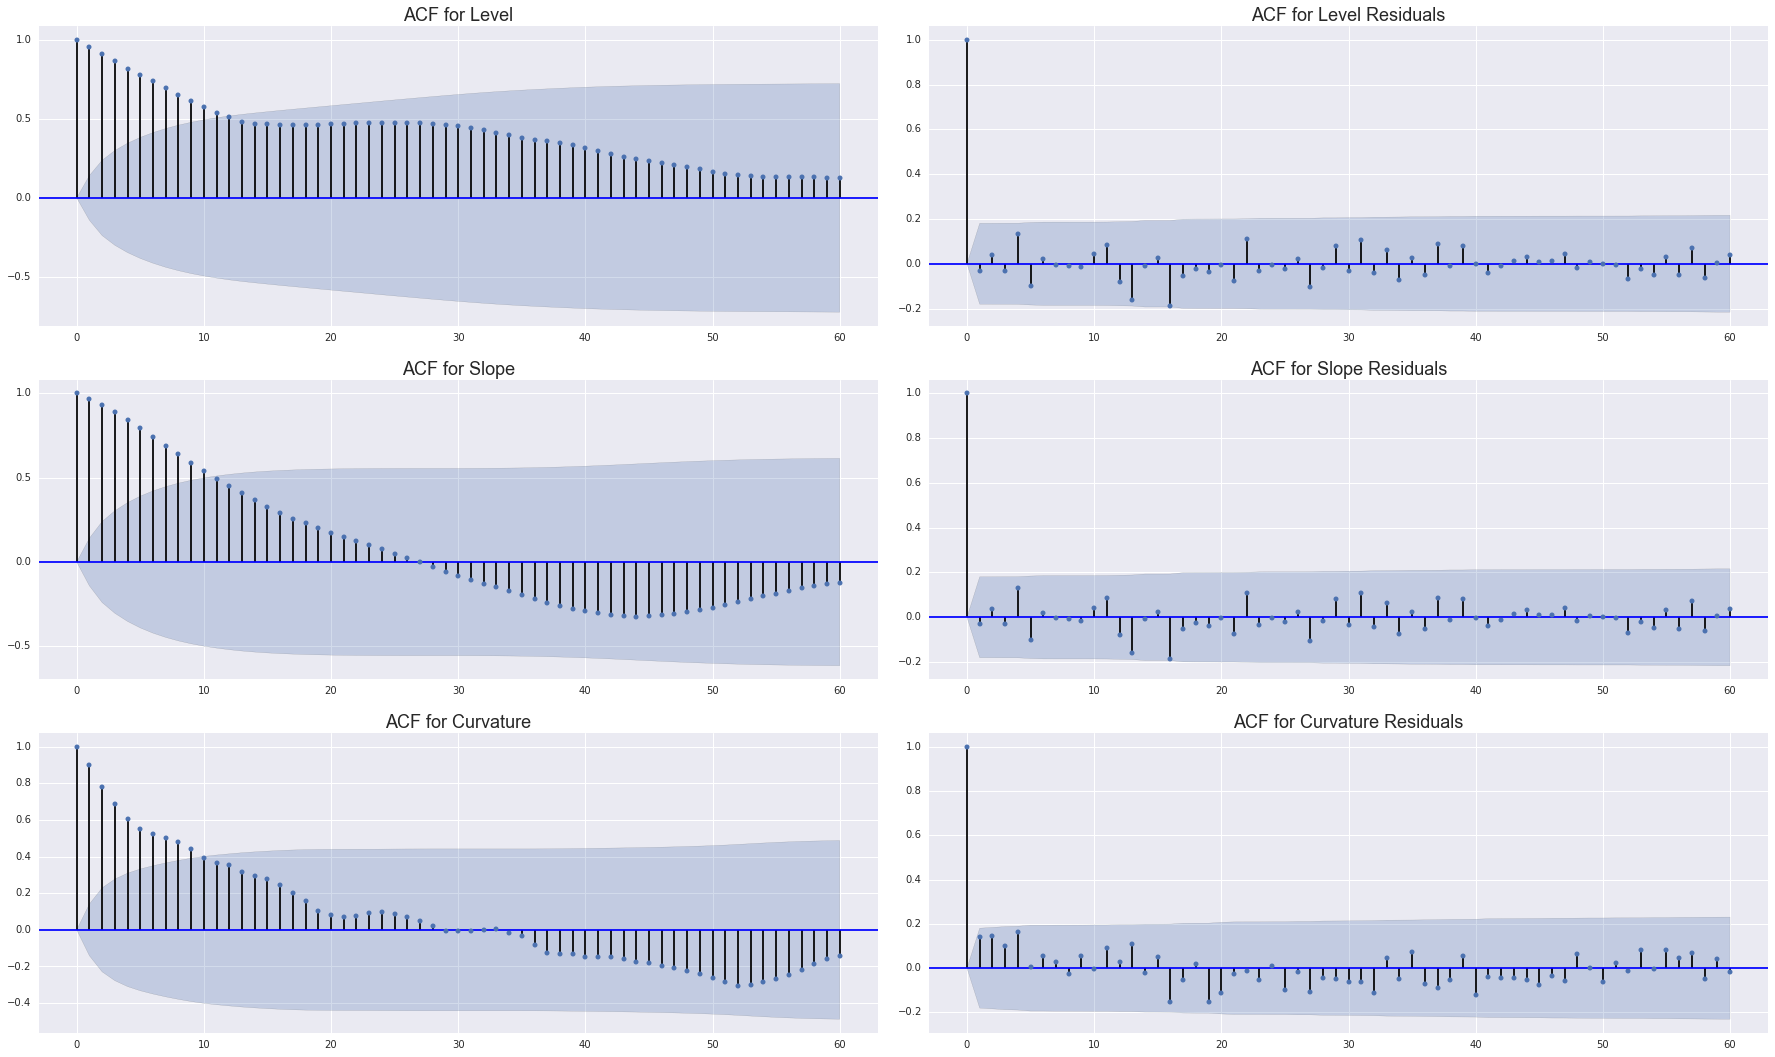

In [606]:
plt.rcParams['font.size'] =  18
titlefont = {'fontsize': 18}
fig = plt.figure(figsize=(25,15))
ax1 = fig.add_subplot(321)
f = sm.graphics.tsa.plot_acf(beta_fits.ix[:,0].values.squeeze(),\
                             lags=60, ax=ax1)
ax1.set_title('ACF for Level', **titlefont)

ax2 = fig.add_subplot(322)
f = sm.graphics.tsa.plot_acf(fitted_resid.ix[:,'beta1'].values.squeeze(),\
                             lags=60, ax=ax2)
ax2.set_title('ACF for Level Residuals', **titlefont)

ax3 = fig.add_subplot(323)
f = sm.graphics.tsa.plot_acf(beta_fits.ix[:,1].values.squeeze(),\
                             lags=60, ax=ax3)
ax3.set_title('ACF for Slope', **titlefont)

ax4 = fig.add_subplot(324)
f = sm.graphics.tsa.plot_acf(fitted_resid.ix[:,'beta2'].values.squeeze(),\
                             lags=60, ax=ax4)
ax4.set_title('ACF for Slope Residuals', **titlefont)

ax5 = fig.add_subplot(325)
f = sm.graphics.tsa.plot_acf(beta_fits.ix[:,2].values.squeeze(),\
                             lags=60, ax=ax5)
ax5.set_title('ACF for Curvature', **titlefont)

ax6 = fig.add_subplot(326)
f = sm.graphics.tsa.plot_acf(fitted_resid.ix[:,'beta3'].values.squeeze(),\
                             lags=60, ax=ax6)
ax6.set_title('ACF for Curvature Residuals', **titlefont)

fig.tight_layout()

# py.offline.plot_mpl(fig)

In [61]:
shape(arange(1000,10000, 100))

(90,)

## Here we are interested in seeing if there is some relation between tau residuals at different forecast dates
we can do this by testing for serial correlation between r(tau=3) and r(tau=3) 3 periods apart. 

In [212]:
grangertest = transpose(vstack((residuals.ix[:,'24'], residuals.ix[:,'9'])));
grangerResults = sm.tsa.stattools.grangercausalitytests(grangertest, maxlag=15, verbose=False);

In [163]:
data = zeros((len(ratedata)-6, 3 ))
for i in range(0, len(ratedata)-6):
    data[i,0] = ratedata.ix[i,9]
    data[i,1] = ratedata.ix[i+3,3]
    data[i,2] = data[i,1] - data[i,0]


In [444]:
diff36 = ratedata.ix[:, '3'] - ratedata.ix[:,'6']
diff36 = diff36-mean(diff36)
layout = go.Layout(
            width=600,
            height=480)

diff36.iplot(kind='scatter', layout=layout)

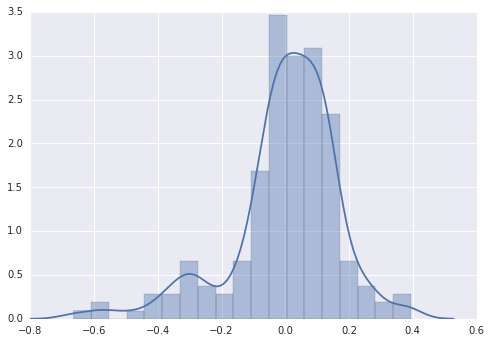

In [449]:
fig, axes = plt.subplots(1,1)
d = sns.distplot(diff36, kde=True)

In [301]:
# model the percent change in the data
beta_change = pd.DataFrame(empty_like(beta_fits_insample), \
    index = beta_fits_insample.index, columns=beta_fits_insample.columns)
for i in range(1,len(beta_fits_insample)):
    beta_change.iloc[i,:] = (beta_fits_insample.iloc[i,:] - beta_fits_insample.iloc[i-1,:]) \
                            /  beta_fits_insample.iloc[i-1,:]*100

In [644]:
beta_change.iplot(kind='scatter')

In [323]:
ff = scipy.fft(ratedata.ix[:,])

In [300]:
(.4732 - .011)/(.011)

42.01818181818182

In [138]:
for mat in maturities:
    tmp = sm.tsa.stattools.adfuller(residuals.ix[:,str(mat)], regression='nc')
    if tmp[1] > .05:
        print mat

6
15
18
21


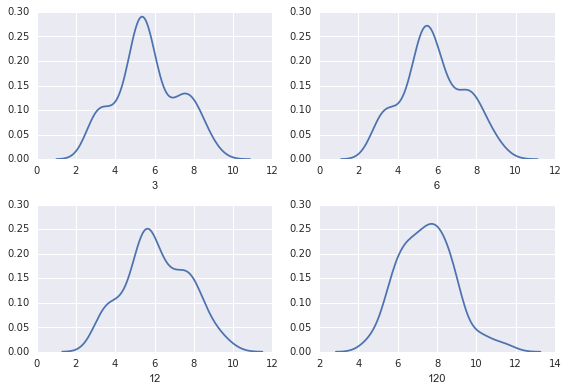

In [243]:
fig, axes = plt.subplots(2,2)
idx = ratedata.index.get_loc(dt.datetime.strptime('1999-01-29', '%Y-%m-%d'))
d = sns.distplot(ratedata.ix[:idx,'3'], kde=True, hist=False, ax=axes[0,0])
d = sns.distplot(ratedata.ix[:idx,'6'], kde=True, hist=False, ax=axes[0,1])
d = sns.distplot(ratedata.ix[:idx,'12'], kde=True, hist=False, ax=axes[1,0])
d = sns.distplot(ratedata.ix[:idx,'120'], kde=True, hist=False, ax=axes[1,1])
plt.tight_layout()

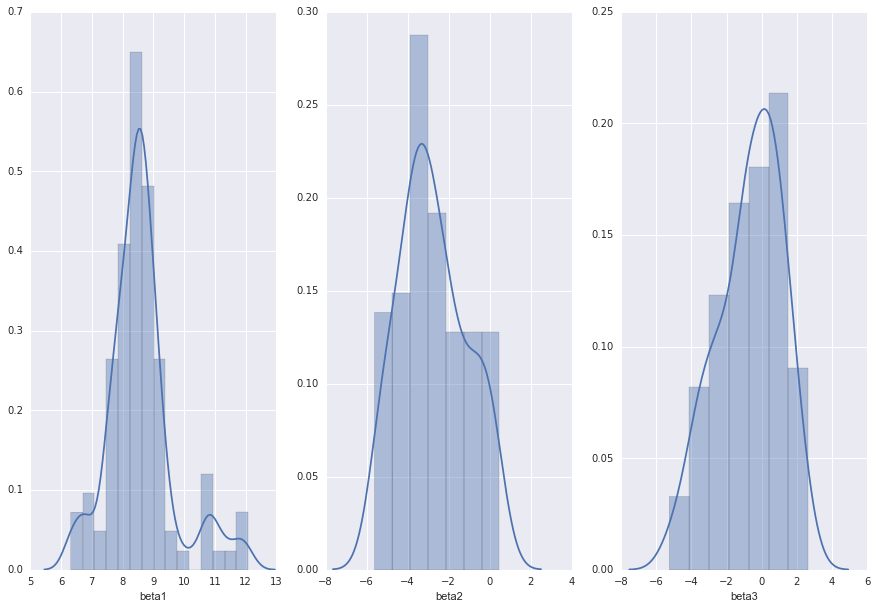

In [778]:
fig, axes = plt.subplots(1,3, figsize=(10,10))
sns.set(font_scale=1)
d = sns.distplot(beta_fits_insample.ix[:,'beta1'], ax=axes[0])
d = sns.distplot(beta_fits_insample.ix[:,'beta2'], ax=axes[1])
d = sns.distplot(beta_fits_insample.ix[:,'beta3'], ax=axes[2])

In [779]:
ratedata.corr().iplot(kind='heatmap')

## USE QUANDL TO GET MORE DATA

In [453]:
token = "32tszwe-Xp9UR3bvaM52"
rawratedata = Quandl.get("USTREASURY/YIELD")

maturities = ["3 MO", "6 MO", "1 YR", "2 YR", "3 YR", \
              "5 YR", "7 YR", "10 YR"]
ratedata = rawratedata[maturities]

In [ ]:
sm.robust.stand_mad

In [468]:
wavelet = pywt.Wavelet('db8')
n = len(ratedata)
levels = int(floor(log2(n)))
waveletcoeff = pywt.wavedec(ratedata.ix[:,'3 MO'], wavelet,\
    level=8, mode='per')
threshold = sm.robust.mad(waveletcoeff[-1])*sqrt(levels)
newWavelet = map(lambda x: pywt.threshold(x, threshold), waveletcoeff)
denoised = pywt.waverec(newWavelet, wavelet)
plt.plot(arange(0,len(denoised)), denoised, arange(0,len(denoised)), ratedata.ix[:,'3 MO'])

//anaconda/lib/python2.7/site-packages/statsmodels/robust/scale.py:49: FutureWarning:

stand_mad is deprecated and will be removed in 0.7.0. Use mad instead.

//anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3558: RuntimeWarning:

Invalid value encountered in median



ValueError: Coefficients arrays must have the same size.

In [473]:
wavelet = pywt.Wavelet('db8')
n = len(ratedata)
levels = int(floor(log2(n)))
waveletcoeff = pywt.wavedec(ratedata.ix[:,'3 MO'], wavelet,\
    level=4, mode='per')
threshold = sm.robust.mad(waveletcoeff[-1])*sqrt(levels)

In [475]:
type()

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''